In [1]:
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from azure.storage.blob import BlobServiceClient

In [2]:
import src.paychex_ml as pml
pml.__file__

In [3]:
from src.paychex_ml.utils import load_credentials

In [4]:
credentials = load_credentials("blob_storage",
                               file="C:/Users/bruno.gonzalez/DataspellProjects/Paychex_revenue_forecast/credentials.yml")

In [5]:
# Start client
container_name = "clean-data"
blob_service_client = BlobServiceClient.from_connection_string(credentials['conn_string'])
container_client = blob_service_client.get_container_client(container_name)

In [6]:
# Download file
file = 'paychex_revenue.parquet'
stream_downloader = container_client.download_blob(file)
stream = BytesIO()
stream_downloader.readinto(stream)

32591

In [7]:
df = pd.read_parquet(stream, engine='pyarrow')

In [8]:
df

00 period  11 Payroll Blended Products  \
Actual   Final Revised FY15          0                 1.273360e+09   
                       FY15          1                 9.963351e+07   
                       FY15          2                 1.216197e+08   
                       FY15          3                 9.947248e+07   
                       FY15          4                 9.419823e+07   
...                                ...                          ...   
Forecast 8+4           FY22          8                 1.038698e+08   
                       FY22          9                 1.033605e+08   
                       FY22         10                 1.167122e+08   
                       FY22         11                 1.020151e+08   
                       FY22         12                 1.081643e+08   

                             12 W2 Revenue  13 Delivery Revenue  \
Actual   Final Revised FY15    93068065.26         1.186875e+08   
                       FY15     7211830.38         7.393352e+06   
                       FY15     7507480.62         1.351374e+07   
                       FY15     7625158.09         7.286967e+06   
                       FY15     7596134.70         7.081862e+06   
...                                    ...                  ...   
Forecast 8+4           FY22    81839910.32         2.243552e+07   
                       FY22       87300.99         6.683674e+06   
                       FY22      -43017.37         7.556914e+06   
                       FY22       44810.81         1.094369e+07   
                       FY22      114155.58         7.961770e+06   

                             14 ASO Allocation  15 Other Processing Revenue  \
Actual   Final Revised FY15        96688929.75                  65680173.19   
                       FY15         7255027.55                   4966982.64   
                       FY15         9070820.80                   6755141.12   
                       FY15         7489159.50                   4393517.15   
                       FY15         7011292.24                   4898467.76   
...                                        ...                          ...   
Forecast 8+4           FY22        17242037.23                  22172231.60   
                       FY22        16746239.66                  15262912.02   
                       FY22        19830263.01                  13878378.94   
                       FY22        17280393.78                  11440096.90   
                       FY22        18341358.09                   7687526.73   

                             16 SurePayroll  17 Total International  \
Actual   Final Revised FY15     41182381.16              9498516.10   
                       FY15      3246967.02               808003.64   
                       FY15      3362473.02               855305.18   
                       FY15      3286111.93               801651.38   
                       FY15      3345328.53               834334.16   
...                                     ...                     ...   
Forecast 8+4           FY22      7943756.66              5022326.69   
                       FY22      7782924.02              4508991.80   
                       FY22      7739255.89              4532101.45   
                       FY22      7880413.73              4385659.84   
                       FY22      7873993.46              4466756.09   

                             20 Total 401k  31 HR Solutions (excl PEO)  \
Actual   Final Revised FY15    200963139.0                 280104498.0   
                       FY15     14883414.0                  21143605.0   
                       FY15     15071771.0                  25838048.0   
                       FY15     14783933.0                  21762760.0   
                       FY15     17075301.0                  20288451.0   
...                                    ...                         ...   
Forecast 8+4           FY22     25826261.0         

# Monthly Actuals

In [9]:
df_month = df[df['00 period']!=0].loc[('Actual','Final Revised'),:].reset_index()

C:\Users\bruno.gonzalez\Miniconda3\envs\azml\lib\site-packages\pandas\core\indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [10]:
df_month['index'] = pd.to_datetime(df_month['00 period'].apply(str) + df_month['index'].str.slice(2), format="%m%y")\
    .dt.to_period('M')

In [11]:
period = df_month.pop('00 period')

In [12]:
df_month = df_month.set_index('index')

In [13]:
df_month.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 84 entries, 2015-01 to 2021-12
Freq: M
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   11 Payroll Blended Products            84 non-null     float64
 1   12 W2 Revenue                          84 non-null     float64
 2   13 Delivery Revenue                    84 non-null     float64
 3   14 ASO Allocation                      84 non-null     float64
 4   15 Other Processing Revenue            84 non-null     float64
 5   16 SurePayroll                         84 non-null     float64
 6   17 Total International                 84 non-null     float64
 7   20 Total 401k                          84 non-null     float64
 8   31 HR Solutions (excl PEO)             84 non-null     float64
 9   40 Total Online Services               84 non-null     float64
 10  50 Other Managment Solutions           84 non-null     f

In [14]:
df_month.describe()

,11 Payroll Blended Products,12 W2 Revenue,13 Delivery Revenue,14 ASO Allocation,15 Other Processing Revenue,16 SurePayroll,17 Total International,20 Total 401k,31 HR Solutions (excl PEO),40 Total Online Services,50 Other Managment Solutions,60 Total PEO,70 Total Insurance Services,80 Interest on Funds Held for Clients
count,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01
mean,1.084483e+08,7.958609e+06,1.003312e+07,1.078326e+07,6.234125e+06,5.098309e+06,2.146622e+06,1.909759e+07,3.140326e+07,1.297825e+07,1.492398e+07,3.910678e+07,1.395553e+07,5.107684e+06
std,9.354400e+06,2.108662e+07,3.986742e+06,2.195401e+06,1.178364e+06,1.554469e+06,1.438746e+06,2.662763e+06,6.162351e+06,2.019918e+06,4.726722e+06,2.225136e+07,2.243022e+06,1.613649e+06
min,9.094933e+07,-2.419720e+05,6.185802e+06,7.011292e+06,3.790476e+06,3.221739e+06,6.728264e+05,1.478393e+07,2.028845e+07,8.581821e+06,6.350954e+06,1.294870e+07,1.008407e+07,3.308153e+06
25%,1.002485e+08,1.814661e+05,7.443607e+06,9.259447e+06,5.411902e+06,4.032447e+06,8.211894e+05,1.685675e+07,2.703527e+07,1.159864e+07,1.352016e+07,1.980987e+07,1.227636e+07,3.840497e+06
50%,1.070092e+08,3.135933e+05,8.252243e+06,1.035877e+07,6.132526e+06,4.729663e+06,1.034863e+06,1.894864e+07,3.014123e+07,1.330167e+07,1.529533e+07,3.146800e+07,1.411706e+07,4.792190e+06
75%,1.155139e+08,7.512116e+06,1.198190e+07,1.235705e+07,6.765924e+06,5.801675e+06,3.577341e+06,2.111923e+07,3.589550e+07,1.441724e+07,1.766897e+07,6.466603e+07,1.554356e+07,6.033108e+06
max,1.286676e+08,9.538279e+07,2.254830e+07,1.605370e+07,1.006668e+07,1.208089e+07,4.400806e+06,2.463041e+07,4.576697e+07,1.724580e+07,2.757900e+07,8.755024e+07,2.207968e+07,1.344751e+07


## Time series plots

11 Payroll Blended Products


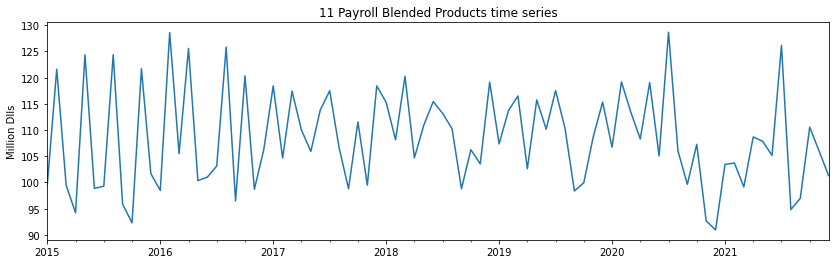

12 W2 Revenue


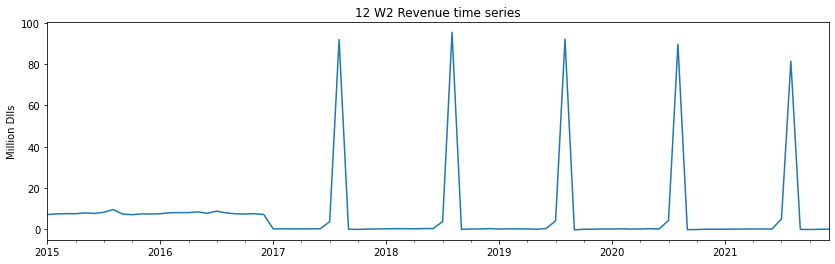

13 Delivery Revenue


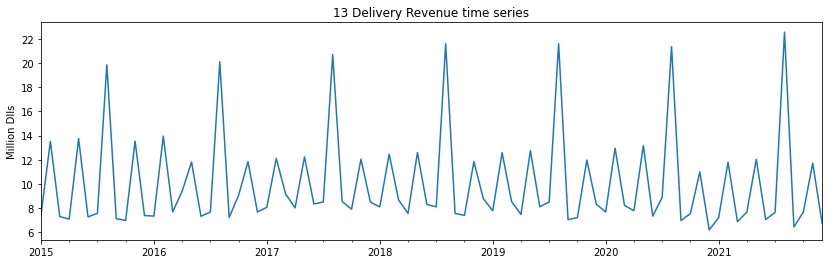

14 ASO Allocation


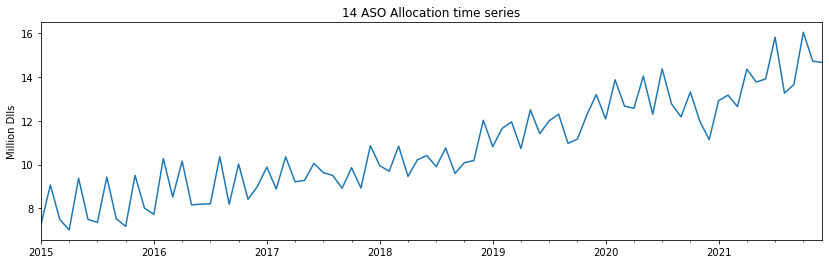

15 Other Processing Revenue


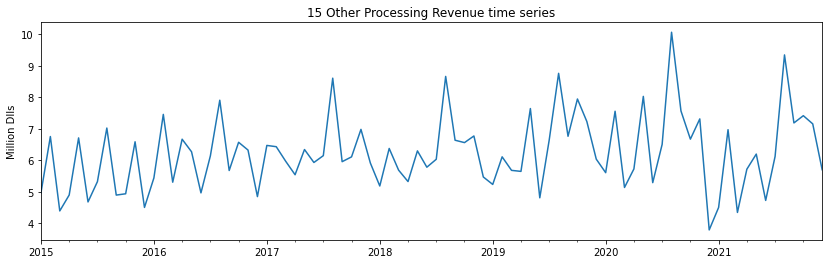

16 SurePayroll


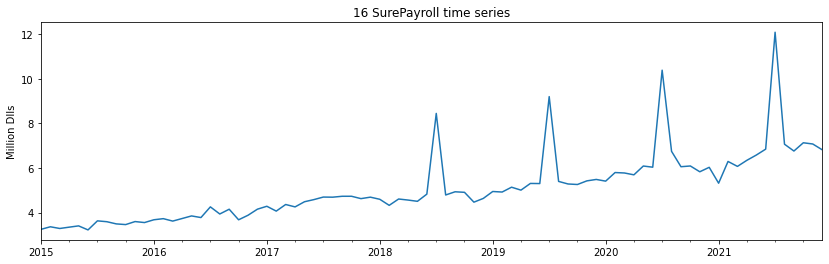

17 Total International


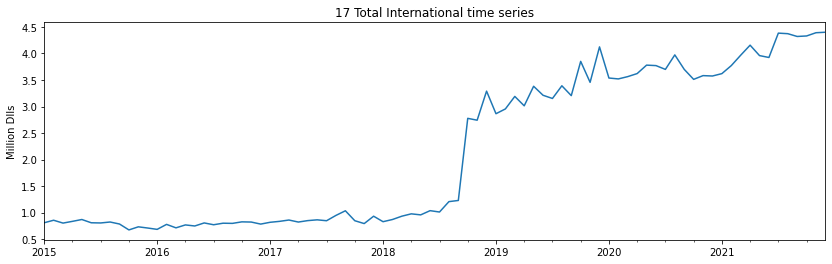

20 Total 401k


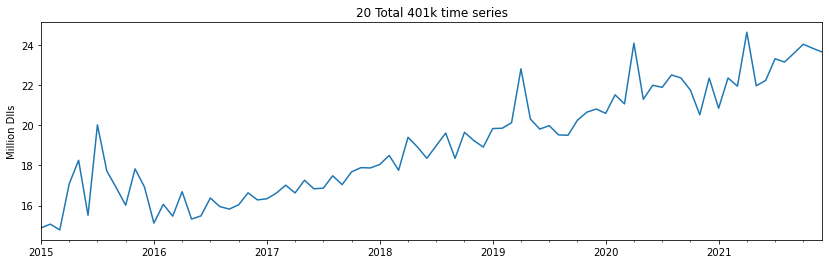

31 HR Solutions (excl PEO)


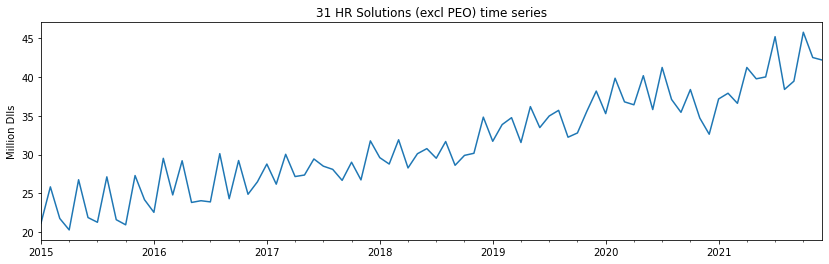

40 Total Online Services


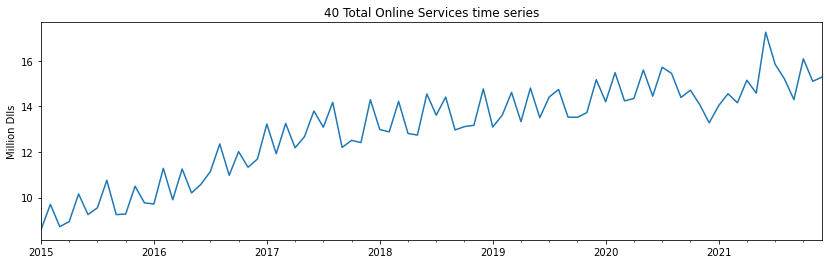

50 Other Managment Solutions


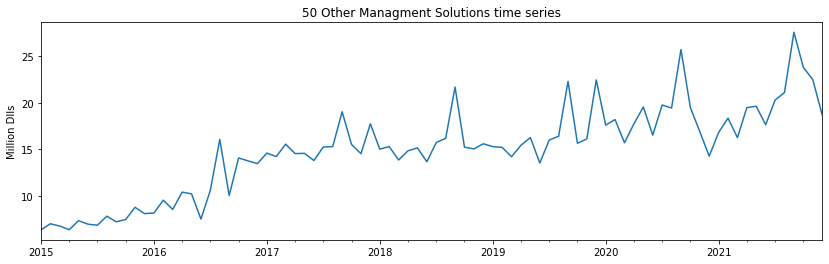

60 Total PEO


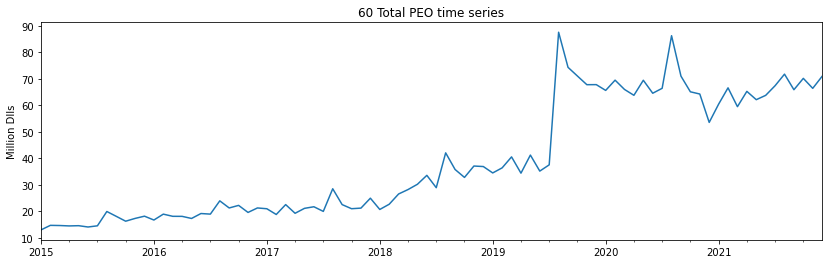

70 Total Insurance Services


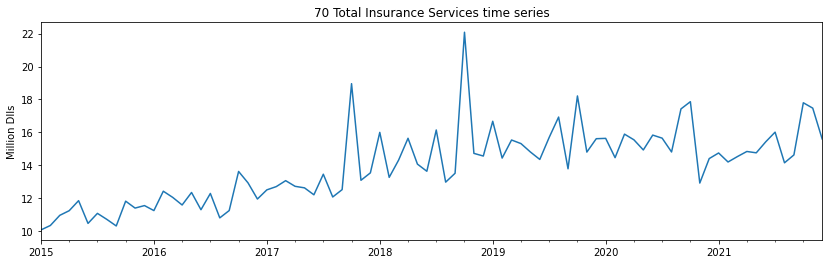

80 Interest on Funds Held for Clients


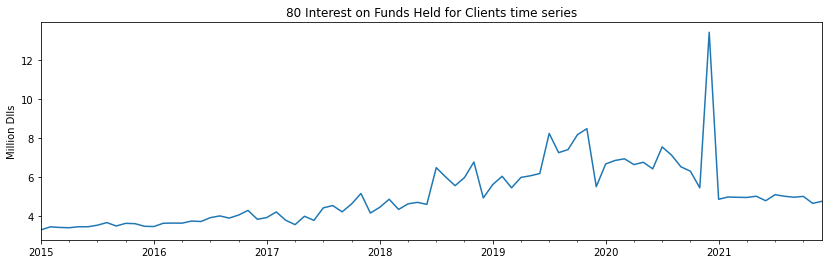

In [15]:
for c in df_month.columns:
    print(c)
    fig, ax = plt.subplots(figsize=(14,4))
    (df_month[c]/1000000).plot(title = c + ' time series', xlabel='', ylabel='Million Dlls', ax=ax)
    #sns.lineplot(data=df_month[c])
    plt.show()

In [16]:
total_revenue = df_month.sum(axis=1)

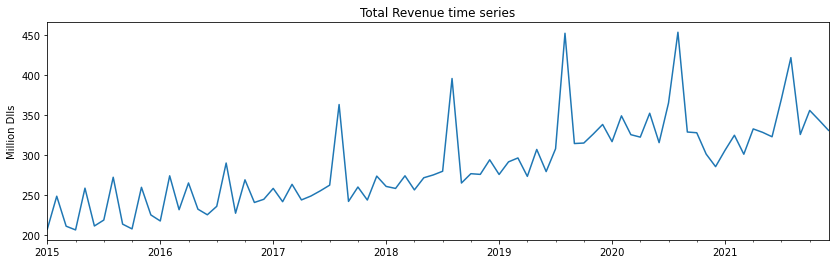

In [17]:
fig, ax = plt.subplots(figsize=(14,4))
(total_revenue/1000000).plot(title = 'Total Revenue time series', xlabel='', ylabel='Million Dlls', ax=ax)
plt.show()

## Participation each item

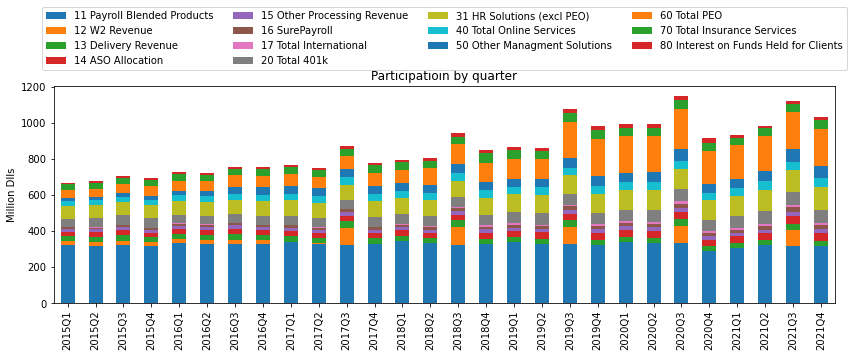

In [20]:
fig, ax = plt.subplots(figsize=(14,4))
(df_month/1000000).resample('Q').sum()\
    .plot.bar(title = 'Participatioin by quarter', xlabel='', ylabel='Million Dlls', stacked=True, ax=ax, legend=False)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=4)
plt.show()

In [21]:
rev_part_y = ((df_month).resample('Y').sum().divide(total_revenue.resample('Y').sum(), axis=0)*100).round(2)

Participation percentage by year

In [22]:
rev_part_y

,11 Payroll Blended Products,12 W2 Revenue,13 Delivery Revenue,14 ASO Allocation,15 Other Processing Revenue,16 SurePayroll,17 Total International,20 Total 401k,31 HR Solutions (excl PEO),40 Total Online Services,50 Other Managment Solutions,60 Total PEO,70 Total Insurance Services,80 Interest on Funds Held for Clients
index,,,,,,,,,,,,,,
2015,46.40,3.39,4.33,3.52,2.39,1.50,0.35,7.32,10.21,4.17,3.17,6.90,4.81,1.53
2016,44.32,3.21,4.09,3.63,2.49,1.57,0.31,6.47,10.58,4.48,4.48,7.95,4.87,1.56
2017,41.87,3.09,3.93,3.65,2.42,1.72,0.33,6.51,10.76,4.93,5.85,8.30,5.05,1.60
2018,39.17,3.02,3.63,3.64,2.21,1.76,0.53,6.67,10.76,4.79,5.53,11.08,5.35,1.88
2019,34.84,2.59,3.22,3.73,2.08,1.76,1.05,6.44,10.88,4.45,5.27,16.62,4.93,2.13
2020,32.07,2.36,2.94,3.79,1.96,1.88,1.08,6.48,10.97,4.35,5.46,19.91,4.59,2.15
2021,31.10,2.16,2.84,4.16,1.86,2.08,1.22,6.78,11.96,4.47,5.96,19.44,4.53,1.46


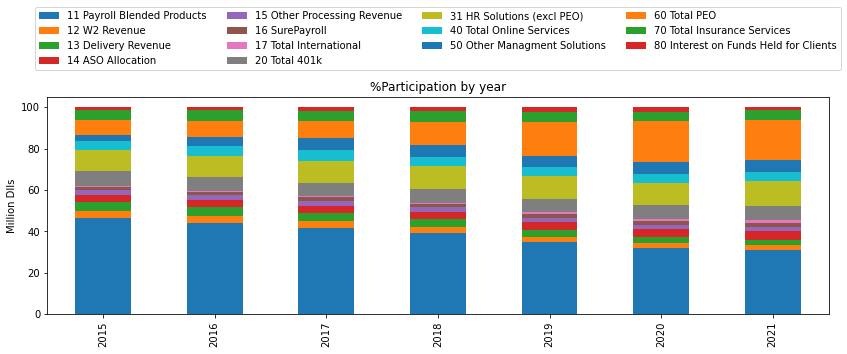

In [23]:
fig, ax = plt.subplots(figsize=(14,4))
rev_part_y.plot.bar(title = '%Participation by year',
                    xlabel='',
                    ylabel='Million Dlls',
                    stacked=True,
                    ax=ax,
                    legend=False)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=4)
plt.show()

## Correlation matrix

In [24]:
rev_cor = df_month.corr()

In [25]:
rev_cor.round(2)

,11 Payroll Blended Products,12 W2 Revenue,13 Delivery Revenue,14 ASO Allocation,15 Other Processing Revenue,16 SurePayroll,17 Total International,20 Total 401k,31 HR Solutions (excl PEO),40 Total Online Services,50 Other Managment Solutions,60 Total PEO,70 Total Insurance Services,80 Interest on Funds Held for Clients
11 Payroll Blended Products,1.00,-0.06,0.26,0.27,0.24,0.16,-0.07,-0.05,0.26,0.24,0.03,-0.07,0.07,-0.08
12 W2 Revenue,-0.06,1.00,0.74,0.00,0.58,0.03,0.01,0.02,0.01,0.10,0.02,0.17,-0.08,0.06
13 Delivery Revenue,0.26,0.74,1.00,0.09,0.76,-0.04,-0.02,-0.00,0.08,0.13,0.04,0.11,-0.15,0.02
14 ASO Allocation,0.27,0.00,0.09,1.00,0.33,0.79,0.89,0.87,1.00,0.90,0.80,0.87,0.65,0.50
15 Other Processing Revenue,0.24,0.58,0.76,0.33,1.00,0.22,0.22,0.22,0.33,0.37,0.41,0.38,0.19,0.19
16 SurePayroll,0.16,0.03,-0.04,0.79,0.22,1.00,0.72,0.74,0.79,0.75,0.68,0.70,0.59,0.52
17 Total International,-0.07,0.01,-0.02,0.89,0.22,0.72,1.00,0.90,0.89,0.77,0.71,0.92,0.66,0.63
20 Total 401k,-0.05,0.02,-0.00,0.87,0.22,0.74,0.90,1.00,0.88,0.79,0.74,0.86,0.67,0.58
31 HR Solutions (excl PEO),0.26,0.01,0.08,1.00,0.33,0.79,0.89,0.88,1.00,0.91,0.82,0.87,0.67,0.51
40 Total Online Services,0.24,0.10,0.13,0.90,0.37,0.75,0.77,0.79,0.91,1.00,0.85,0.79,0.70,0.55


<ipython-input-26-e97da9029b9c>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


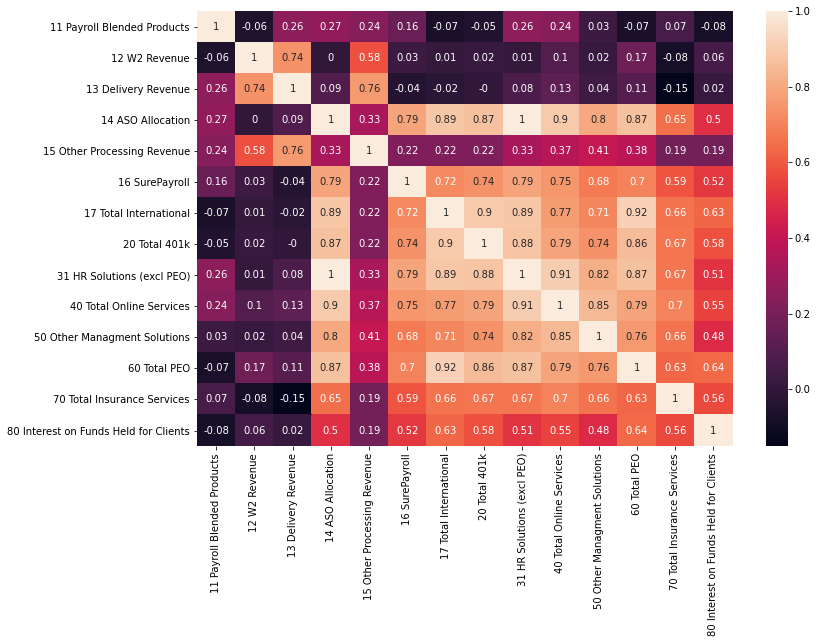

In [26]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(rev_cor.round(2), annot=True, ax=ax)
fig.show()

# Monthly Forecast

In [27]:
df_forecast = df[df['00 period']!=0].loc['Forecast',:].reset_index(level=1)

In [28]:
_ = df_forecast.pop('level_1')

In [29]:
df_forecast = df_forecast.set_index('00 period', append=True)

In [30]:
df_forecast

11 Payroll Blended Products  12 W2 Revenue  \
     00 period                                               
2+10 1                          114237978.0      146014.28   
     2                          113185861.0      129589.02   
     3                          118279683.0      174958.27   
     4                          113299415.0      228960.00   
     5                          105301457.0      183538.79   
...                                     ...            ...   
8+4  8                          103869768.0    81839910.32   
     9                          103360524.0       87300.99   
     10                         116712202.0      -43017.37   
     11                         102015093.0       44810.81   
     12                         108164336.0      114155.58   

                13 Delivery Revenue  14 ASO Allocation  \
     00 period                                           
2+10 1                   7829826.55        17035990.52   
     2                  12439360.29        16379137.69   
     3                   7682000.12        17303717.40   
     4                   7149703.22        16962579.43   
     5                  11224091.41        15652940.90   
...                             ...                ...   
8+4  8                  22435519.84        17242037.23   
     9                   6683673.54        16746239.66   
     10                  7556913.86        19830263.01   
     11                 10943693.27        17280393.78   
     12                  7961770.17        18341358.09   

                15 Other Processing Revenue  16 SurePayroll  \
     00 period                                                
2+10 1                           7463885.63      7156491.88   
     2                           7623829.39      7317227.02   
     3                           5970100.45      6946925.22   
     4                           6435361.37      7143051.58   
     5                           6924622.68      7401163.00   
...                                     ...             ...   
8+4  8                          22172231.60      7943756.66   
     9                          15262912.02      7782924.02   
     10                         13878378.94      7739255.89   
     11                         11440096.90      7880413.73   
     12                          7687526.73      7873993.46   

                17 Total International  20 Total 401k  \
     00 period                                          
2+10 1                      4724626.92     24192007.0   
     2                      4343115.44     24136559.0   
     3                      4290982.72     24568954.0   
     4                      4629587.00     26121057.0   
     5                      4482787.87     24429351.0   
...                                ...            ...   
8+4  8                      5022326.69     25826261.0   
     9                      4508991.80     24740442.0   
     10                     4532101.45     25937318.0   
     11                     4385659.84     25600810.0   
     12                     4466756.09     26080025.0   

                31 HR Solutions (excl PEO)  40 Total Online Services  \
     00 period                                                         
2+10 1                          48479296.0                17751654.0   
     2                          46831114.0                15854559.0   
     3                          49270518.0                15563271.0   
     4                          48319641.0                16818757.0   
     5                          44798802.0                15856089.0   
...                                    ...                       ...   
8+4  8                          49289702.0                17506095.0   
     9                          47754765.0                16548145.0   
     10                         55976261.0                18121060.0   
     11                         49129952.0                16694979.0   
     12                     

In [31]:
I = df_forecast.index.get_level_values(0).unique()
J = df_forecast.columns

11 Payroll Blended Products


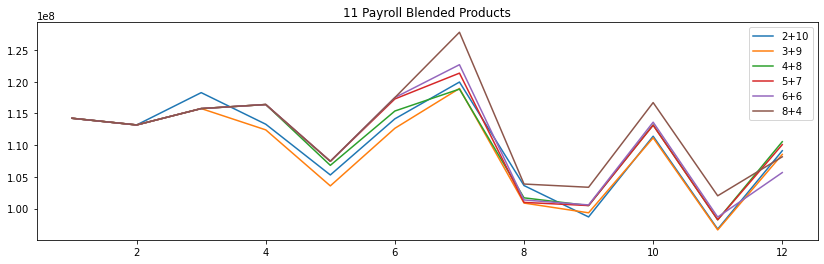

12 W2 Revenue


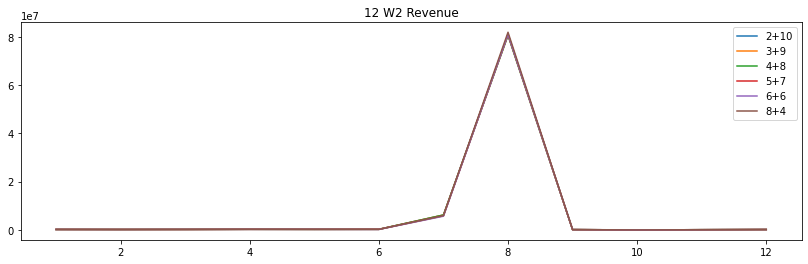

13 Delivery Revenue


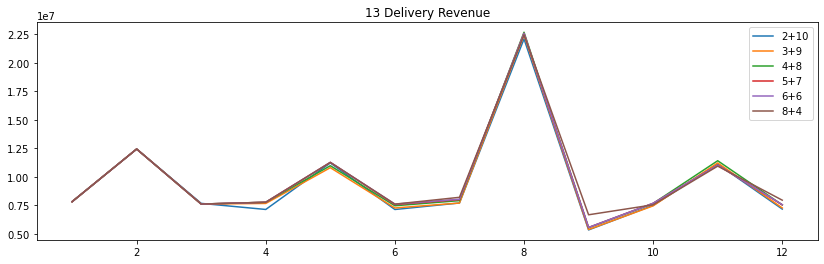

14 ASO Allocation


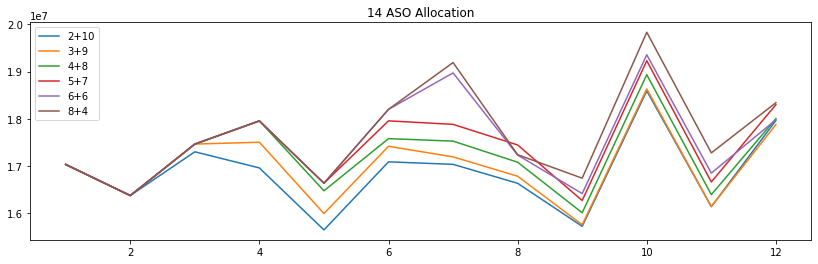

15 Other Processing Revenue


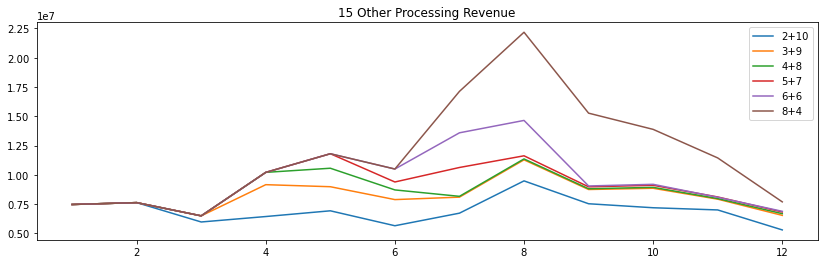

16 SurePayroll


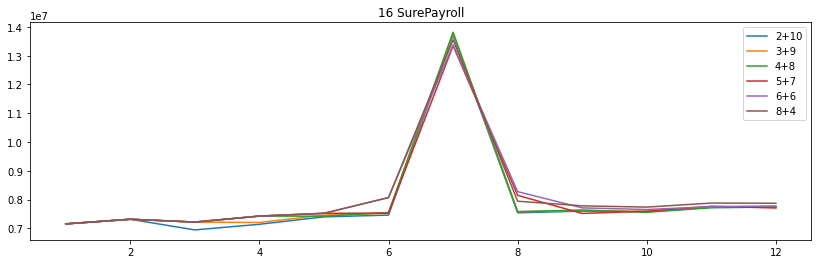

17 Total International


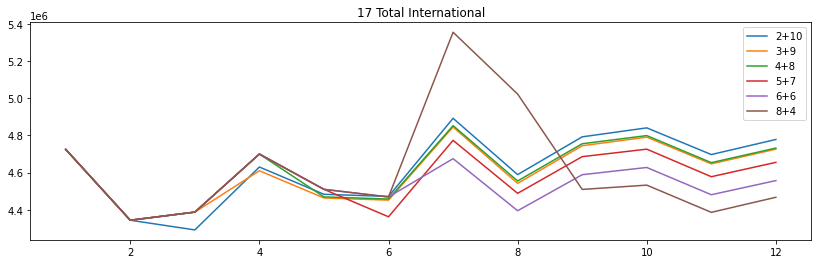

20 Total 401k


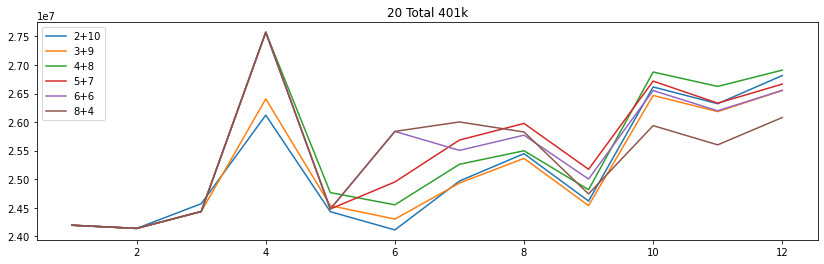

31 HR Solutions (excl PEO)


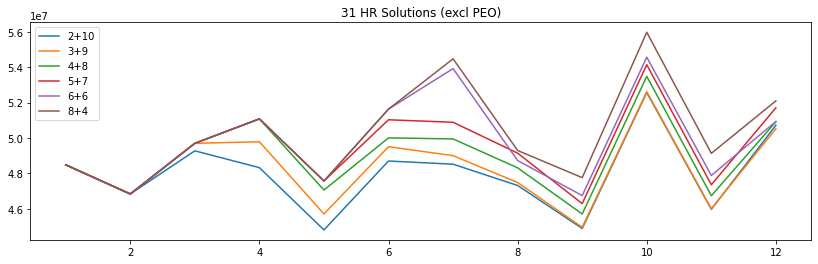

40 Total Online Services


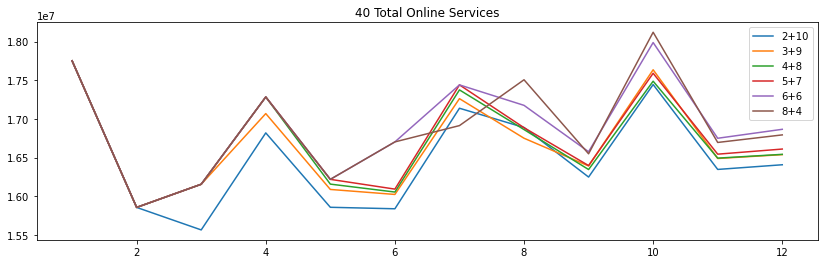

50 Other Managment Solutions


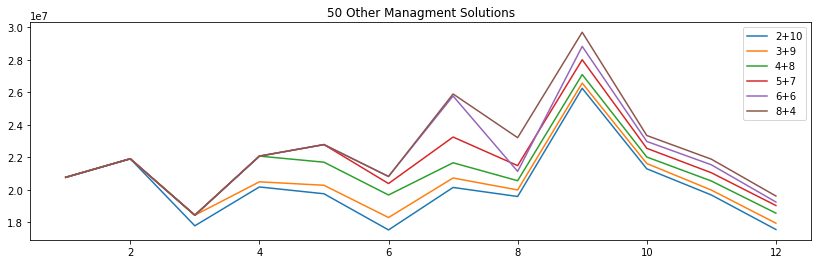

60 Total PEO


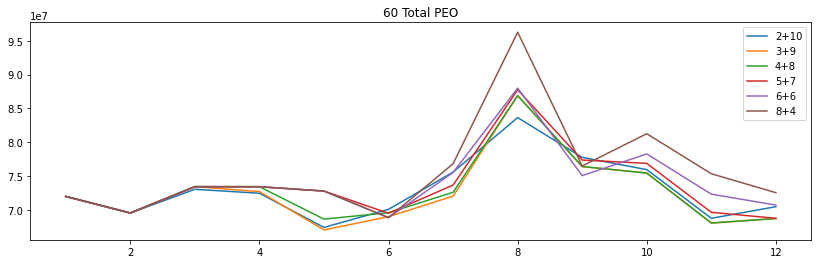

70 Total Insurance Services


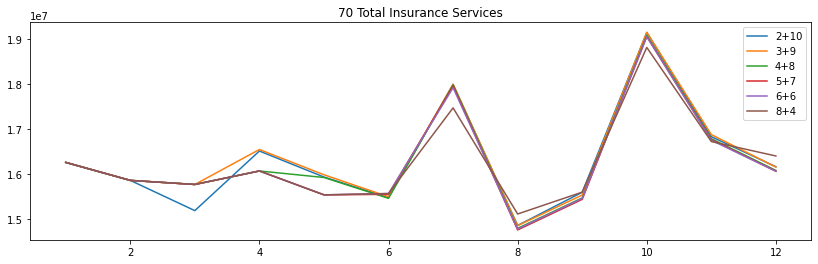

80 Interest on Funds Held for Clients


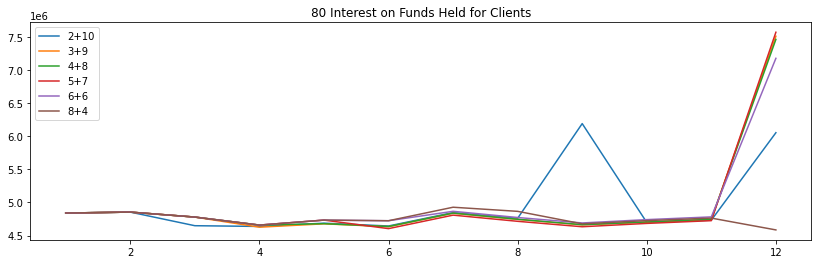

In [32]:
for j in J:
    print(j)
    fig, ax = plt.subplots(figsize=(14,4))
    for i in I:
        plt.plot(df_forecast.loc[i,j], label = i)
    plt.legend()
    plt.title(j)
    plt.show()